# NEW YORK CITY TAXI - ANALYSIS, RECOMMENDATIONS, PREDICTIONS

# <font color="teal">PART 3 - EARNINGS OPTIMISATION AND HOTSPOTS</font>

This part of research addresses the primary goal of Data Science to provide some recommendations to taxi owners to maximise return, minimise working hours and quickly calculate new pickup hotspot for a driver.

## Objective
Research on Questions:
1) If you were a taxi owner, how would you maximize your earnings in a day?
2) If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset?
3) If you run a taxi company with 10 taxis, how would you maximize your earnings?

## Approach
Minimize driver's waiting time by identifying hotspots near the current driver location at given time. For example, if the last dropoff in Long Island at 3 pm, we need to move to the best nearby hotspot for next pickup.

## Technical Solutions 

Rank the best pickup hotspots near the current driver location at given time. It can be achievable by
1) Direct data mining, or
2) Creating and applying a special ML model

# 3.1. Get Data

In [73]:
library('lubridate')
library('dplyr')
library('rlang')
library("ggplot2")
library("ggmap")
library('plyr')
library("sqldf")

In [74]:
############### Read Data from files #################################
trips <- read.csv("trips_notebook.csv")
head(trips, 5)

X hack_license                     pickup_datetime     dropoff_datetime   
1 1 AD8751110E6292079EB10EB9481FE1A6 2013-04-04 18:47:45 2013-04-04 19:00:25
2 2 E1B595FD55E4C82C1E213EB17438107A 2013-04-04 17:59:50 2013-04-04 18:21:48
3 3 16BB0D96A0DCC853AEC7F55C8D6C71E0 2013-04-04 18:12:01 2013-04-04 18:25:24
4 4 579C41EA5EC846F8B641A42F9EE3E855 2013-04-04 20:12:57 2013-04-04 20:29:55
5 5 1B4E92431F9DA4D49874EC76E769E874 2013-04-05 02:48:11 2013-04-05 02:51:21
  trip_time_in_secs trip_distance pickup_longitude pickup_latitude
1  759              2.5           -73.95785        40.76532       
2 1318              3.6           -73.98288        40.75499       
3  799              1.9           -73.97812        40.76345       
4 1017              3.6           -74.00637        40.74475       
5  189              0.7           -73.98519        40.75493       
  dropoff_longitude dropoff_latitude fare_amount tip_amount total_amount
1 -73.97627         40.78565         11.0        2.50       15.00       
2 -74.00919         40.71537         16.5        3.60       21.60       
3 -73.95567         40.77664         10.0        3.45       14.95       
4 -73.96166         40.76108         15.0        3.20       19.20       
5 -73.99078         40.74800          4.5        1.10        6.60       
  pickup_hour pickup_weekday
1 18          5             
2 17          5             
3 18          5             
4 20          5             
5  2          6

In [75]:
## Remove contraversial data with the same pickup and dropoff location for some trips
trips <- subset(trips, (pickup_longitude != dropoff_longitude) | (pickup_latitude != dropoff_latitude))

# 3.2. Calculate Daily, Total and Average Figures

In [76]:
totalDays <- n_distinct(lubridate::date(trips$pickup_datetime))

# Number of taxis
nofTaxis <- n_distinct(trips$hack_license)

# Total profit
totalProfit <- sum(trips$total_amount)

# Average earnings per taxi
avEarningsPerTaxi <- totalProfit/nofTaxis
avTaxiProfitPerDay <- avEarningsPerTaxi/totalDays

In [77]:
print(sprintf("totalDays = %s", totalDays))
print(sprintf("nofTaxis = %s", nofTaxis))
print(sprintf("totalProfit = %s", totalProfit))
print(sprintf("avEarningsPerTaxi = %s", avEarningsPerTaxi))
print(sprintf("avTaxiProfitPerDay = %s", avTaxiProfitPerDay))

[1] "totalDays = 30"
[1] "nofTaxis = 32893"
[1] "totalProfit = 213954376.6"
[1] "avEarningsPerTaxi = 6504.55648922265"
[1] "avTaxiProfitPerDay = 216.818549640755"


# 3.3. Create Map of spots and hours

In [78]:
CreateSpotsHourMap <- function (minNofPickups = 9) {
  # Consolidate Spots and Revenue per Spot per Week per Hour
  return(subset(sqldf(sprintf("SELECT ROUND(pickup_longitude, 3) AS long,
                        ROUND(pickup_latitude, 3) AS lat,
                        pickup_weekday, pickup_hour,
                        COUNT(*) AS num_pickups,
                        sum(total_amount) AS total_revenue,
                        avg(total_amount) AS av_revenue
                        FROM trips
                        WHERE trip_time_in_secs > 0
                        GROUP BY lat, long, pickup_weekday, pickup_hour
                        HAVING COUNT(*) > %s
                        ORDER BY pickup_weekday, pickup_hour", minNofPickups)
  )))
}
spots <- CreateSpotsHourMap()
head(spots)
nrow(spots)

long    lat    pickup_weekday pickup_hour num_pickups total_revenue
1 -73.788 40.641 1              0           10           509.81      
2 -73.787 40.641 1              0           23          1016.24      
3 -73.789 40.642 1              0           14           556.63      
4 -73.787 40.642 1              0           11           637.77      
5 -73.786 40.642 1              0           15           938.21      
6 -73.791 40.644 1              0           11           476.93      
  av_revenue
1 50.98100  
2 44.18435  
3 39.75929  
4 57.97909  
5 62.54733  
6 43.35727

[1] 295440

# 3.4. <font color="green">Hotspots Calculator</font> for given hour and location

In [79]:
GetNearbyHotSpots <- function (long, lat, weekday, hour, nof_records = 5) {
  # Get spots close to given spot for a particular weekday and hour
  query = sprintf("SELECT long, lat, av_revenue, num_pickups, 
                  SQRT(SQUARE(long-(%s)) + SQUARE(lat-(%s))) AS Dist
                  FROM spots
                  WHERE ROUND(long, 1)=ROUND(%s,1) AND ROUND(lat, 1)==ROUND(%s,1) AND pickup_weekday=%s AND pickup_hour=%s 
                  ORDER BY av_revenue DESC, Dist, num_pickups DESC", long, lat, long, lat, weekday, hour)
  # print(query)
  return(subset(sqldf(query))[1:nof_records,])
}

In [80]:
# Examples:
GetNearbyHotSpots(-73.78726, 40.64111 , 1, 0)
GetNearbyHotSpots(-74.023, 40.766, 3, 8)
GetNearbyHotSpots(-73.94, 40.75, 6, 11)

long    lat    av_revenue num_pickups Dist        
1 -73.786 40.642 62.54733   15          0.0015426276
2 -73.787 40.642 57.97909   11          0.0009272001
3 -73.790 40.647 57.01487   39          0.0064961296
4 -73.789 40.647 52.26444   18          0.0061416366
5 -73.788 40.641 50.98100   10          0.0007481310

long    lat    av_revenue num_pickups Dist      
1 -73.986 40.760 22.69356   87          0.03748333
2 -73.961 40.812 22.01636   22          0.07720104
3 -73.950 40.788 21.72500   12          0.07624303
4 -73.978 40.762 21.65836   55          0.04517743
5 -73.985 40.762 21.25950   20          0.03820995

long    lat    av_revenue num_pickups Dist      
1 -73.864 40.770 42.45203   133         0.07858753
2 -73.863 40.769 42.31604   462         0.07930952
3 -73.871 40.773 41.68455    22         0.07273239
4 -73.863 40.770 41.56289    97         0.07955501
5 -73.864 40.769 41.37325    40         0.07833901

In [81]:
GetNearbyHotSpots(-73.99094, 40.73605, weekday = 1, hour = 8) ### Union Square

long    lat    av_revenue num_pickups Dist      
1 -74.013 40.704 31.54500   10          0.03890818
2 -74.014 40.709 30.32308   13          0.03554527
3 -74.016 40.715 28.90592   49          0.03272776
4 -74.014 40.718 27.62273   11          0.02928423
5 -73.987 40.722 26.34500   10          0.01459199

In [82]:
gc()

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3772228  201.5  11026266   588.9  18369656  981.1
Vcells 210672022 1607.3 582082712  4441.0 726620611 5543.7

## <font color="maroon">Future use - Deploy the calculator to Web Service for general usage</font>

## 3.5. Visualize City Taxi Revenue Heatmap

In [83]:
# Use external script to Draw maps
source('MapPalette.R')

In [84]:
DrawMap <- function(ds, chartLabel = "Total Revenue for NYC Taxis by Pickup Location", thresHold = 10^5) 
{
  # Helper function to make bins not show if total revenue is below threshold
    total_rev <- function(x, minLevel = thresHold) {
    if (sum(x) < minLevel) {return (NA)}
        else {return (sum(x))}
  }
  plot <- ggplot(ds, aes(x=long, y=lat, z=total_revenue)) +
    geom_point(size=0.06, color="#999999") +
    stat_summary_hex(fun = total_rev, bins=100, alpha=0.5) +
    scale_x_continuous(limits=c(-74.0224, -73.8521)) +
    scale_y_continuous(limits=c(40.6959, 40.8348)) +
    theme_map_dark() +
    scale_fill_gradient(low="#FFFFFF", high="#E74C3C", labels=dollar, trans="log", breaks=c(10^(6:8))) +
    labs(title = chartLabel) + coord_equal()

  #png("nyc-taxi-rev.png", w=900, h=900, res=300)
  plot
  #dev.off()
}

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"Warning message:
"Removed 8284 rows containing non-finite values (stat_summary_hex)."Warning message:
"Removed 8284 rows containing missing values (geom_point)."Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

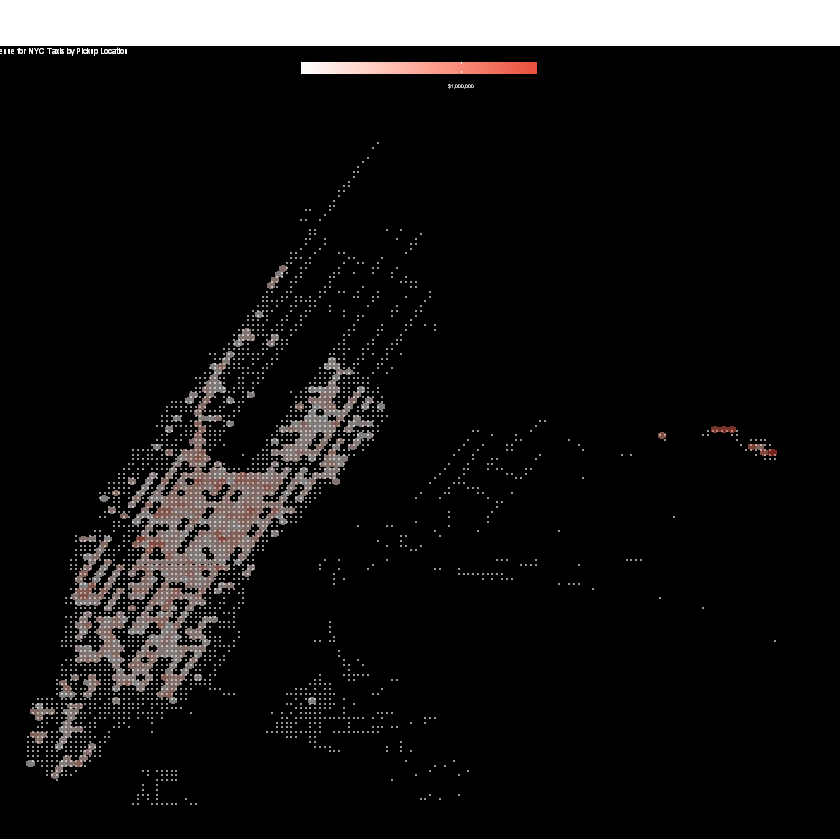

In [85]:
DrawMap(spots)

### <font color="maroon">Observation - BEST HOTSPOTS - JFK Airport and Mathattan</font>

## 3.6. Top Hotspots

In [86]:
# Find average revenue accross all hotspots
print(av <- mean(spots$av_revenue))

[1] 14.34064


Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"Warning message:
"Removed 7472 rows containing non-finite values (stat_summary_hex)."Warning message:
"Removed 7472 rows containing missing values (geom_point)."Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

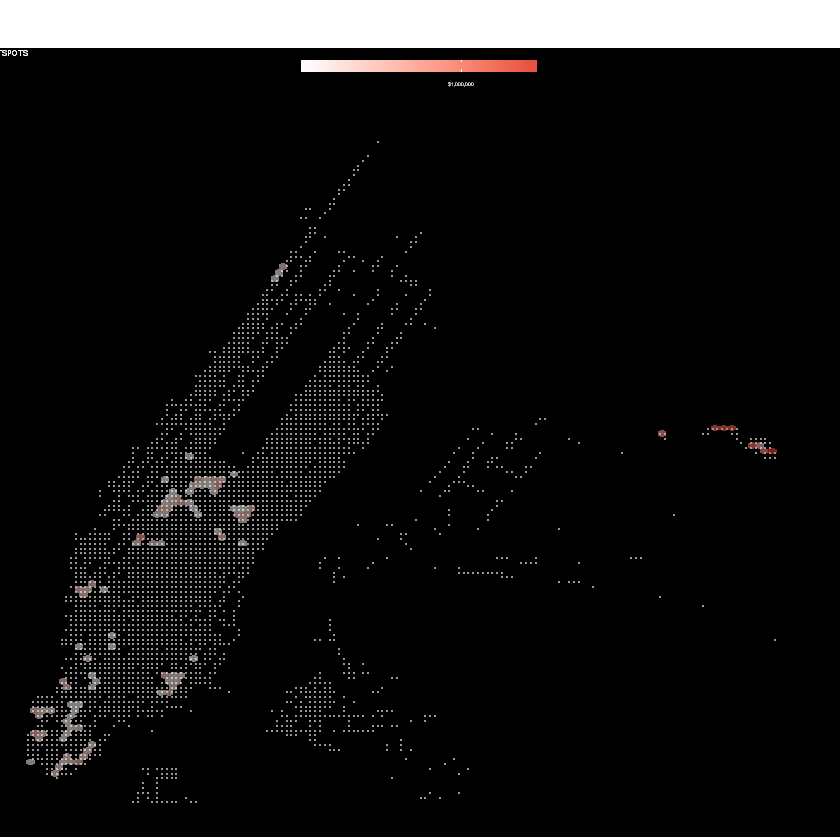

In [87]:
DrawMap(spots[spots$av_revenue > av,], "TOP HOTSPOTS")

### <font color="maroon">TOP HOTSPOTS in Mathattan and JFK Airport</font>

## 3.7. Optimising work time while retaining average wages

Question - If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset? 

Suggestion - Work only the best hours. Technical solution - Ranking hotspots by average hourly earnings, with filter above the average wages accross the dataset

### 3.7.1. Revenue distribution by hour

In [88]:
#####################################################################################################################
RevenueByHour <- function(nof_taxis) {
  # Average Wages by Hour
  return (subset(sqldf(sprintf("SELECT pickup_hour as hour, sum(total_amount)/%s AS revenue_driver
                               FROM trips
                               GROUP BY pickup_hour
                               ORDER BY pickup_hour", nof_taxis)
        )))
}
revByHour <- RevenueByHour(nofTaxis)

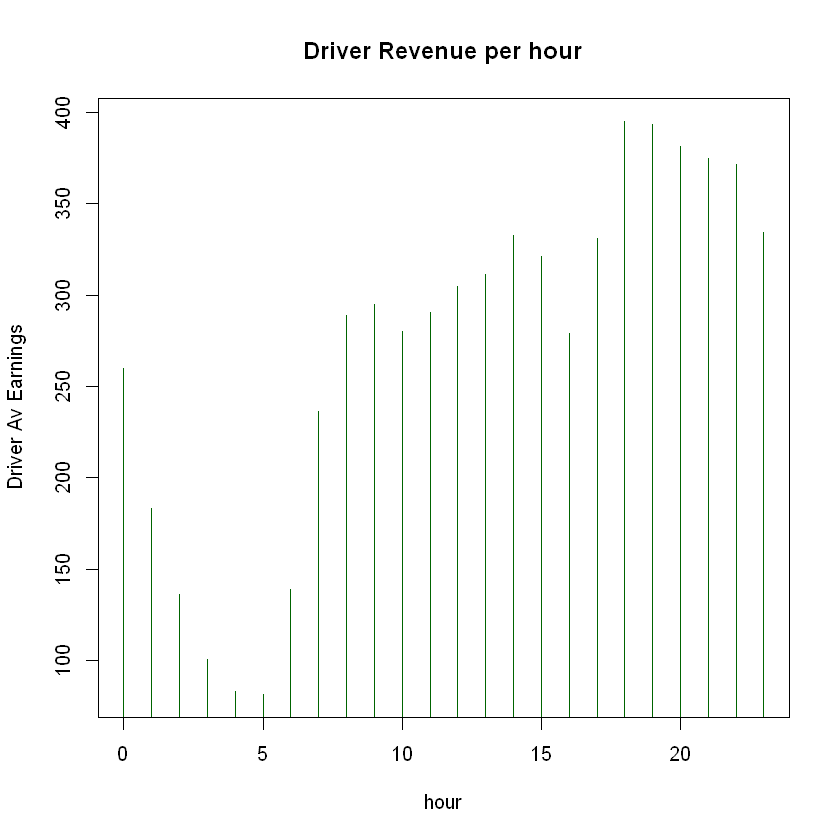

In [89]:
#barchart(table(revByHour$hour, revByHour$revenue_driver))
#barplot(table(revByHour$hour, revByHour$revenue_driver))
plot(revByHour$hour, revByHour$revenue_driver, type="h", main = "Driver Revenue per hour", 
     col="darkgreen", xlab="hour", ylab="Driver Av Earnings")
#revByHour

## 3.7.2. Best working hours to earn above average wages

In [90]:
# Select hours where the earnings is above the average Earnings Per Taxi an hour
recommemdedHours <- subset(revByHour, revenue_driver > avEarningsPerTaxi/24)
#recommemdedHours

In [91]:
# Best Earning Hours
recommemdedHours[order(recommemdedHours$revenue_driver, decreasing = TRUE),]

hour revenue_driver
19 18   395.1752      
20 19   393.2808      
21 20   381.3568      
22 21   374.9495      
23 22   371.5697      
24 23   334.4885      
15 14   332.4551      
18 17   331.2735      
16 15   321.3089      
14 13   311.5113      
13 12   304.7458      
10  9   294.9059      
12 11   290.5522      
9   8   288.6821      
11 10   280.2056      
17 16   278.9583

### <font color='maroon'>Recommendations - work late hours 17-23, sleep at night, another slot - 8am onwards</font>

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"Warning message:
"Removed 121 rows containing non-finite values (stat_summary_hex)."Warning message:
"Removed 121 rows containing missing values (geom_point)."Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

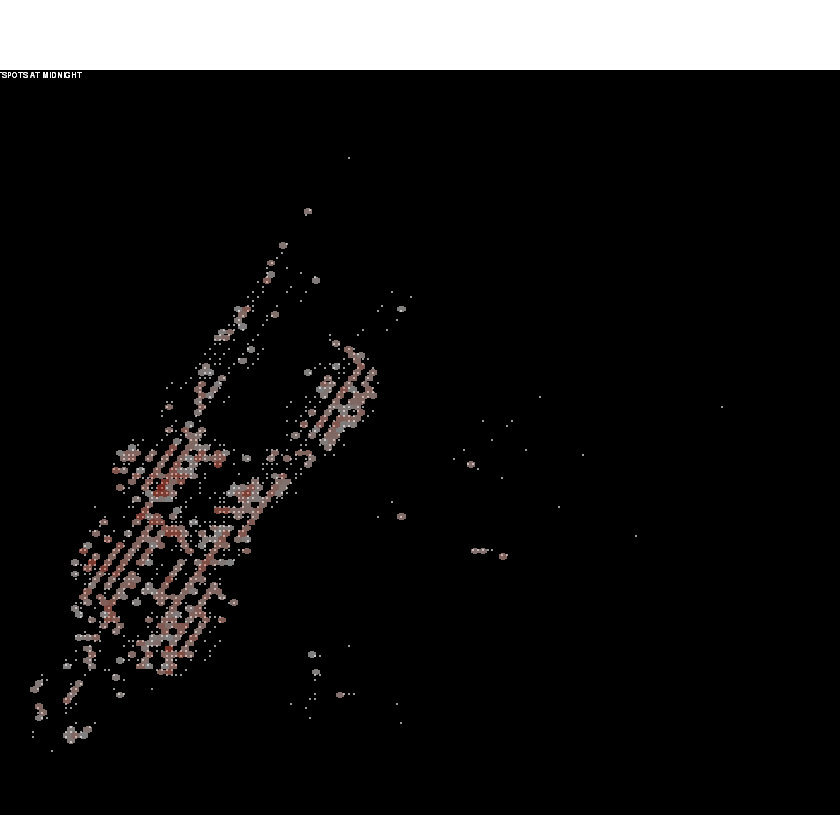

In [92]:
### 3.7.2. Top hotspots for a particular area
DrawMap(spots[spots$pickup_hour == 5,], "TOP HOTSPOTS AT MIDNIGHT", thresHold = 10^3)

### <font color="maroon">CITY NEVER SLEEPS - BEST HOTSPOT at 5am at Mathattan rather than JFK Airport</font>

## 3.8. Optimisation of earnings for a Taxi Company

#### <font color='darkblue'>Question - If you run a taxi company with 10 taxis, how would you maximize your earnings?</font>

Suggestion 1. - Diversify earnings by spreading operations across different clusters

### 3.8.1. Clustering city areas

In [93]:
gc()
spots$cluster <- NULL
#####################################################################################################################
# Clustering locations to identify 10 areas with busy locations
#####################################################################################################################
km.out = kmeans(spots[,1:2], 10, nstart=20, iter.max = 100)

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3772184  201.5  11026266   588.9  18369656  981.1
Vcells 210439628 1605.6 582082712  4441.0 726620611 5543.7

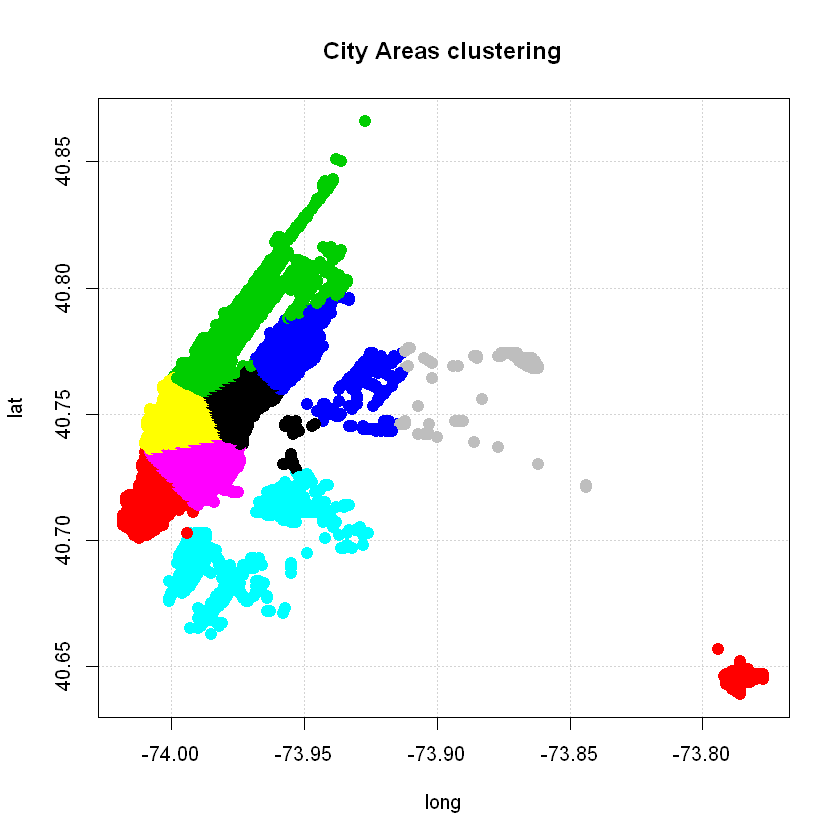

In [94]:
plot(spots[,1:2], col=(km.out$cluster+1), main="City Areas clustering", pch=20, cex=2, panel.first=grid())

In [95]:
# Merge cluster in Spots
spots$cluster = km.out$cluster

### 3.7.2. Identify hotspots in every cluster

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

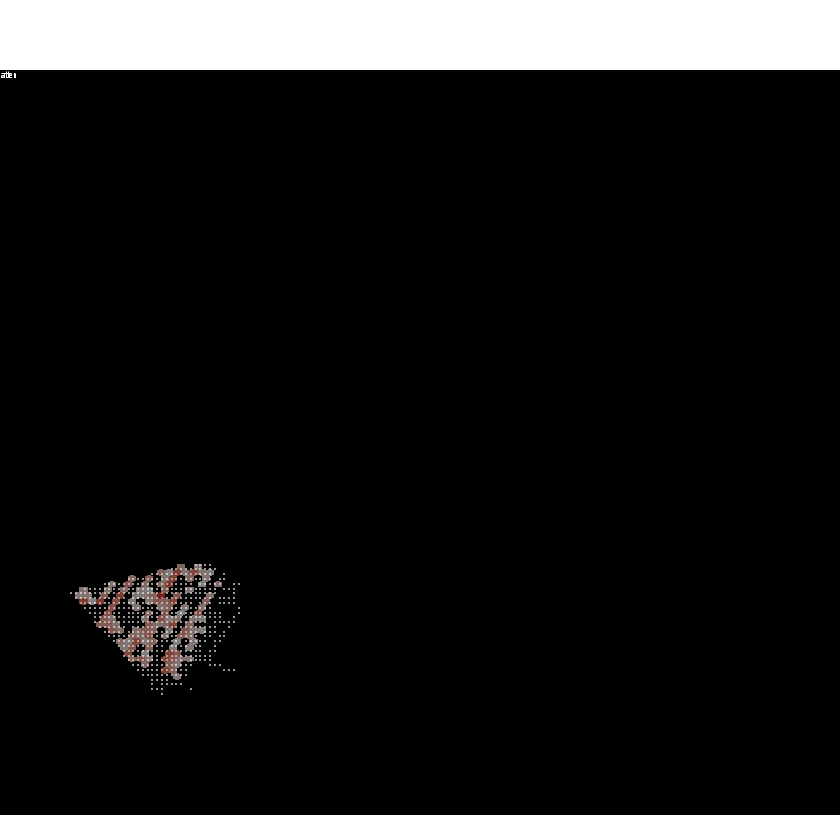

In [96]:
DrawMap(spots[spots$cluster == 5,], "Low Manhatten")

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"Warning message:
"Removed 205 rows containing non-finite values (stat_summary_hex)."Warning message:
"Removed 205 rows containing missing values (geom_point)."Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

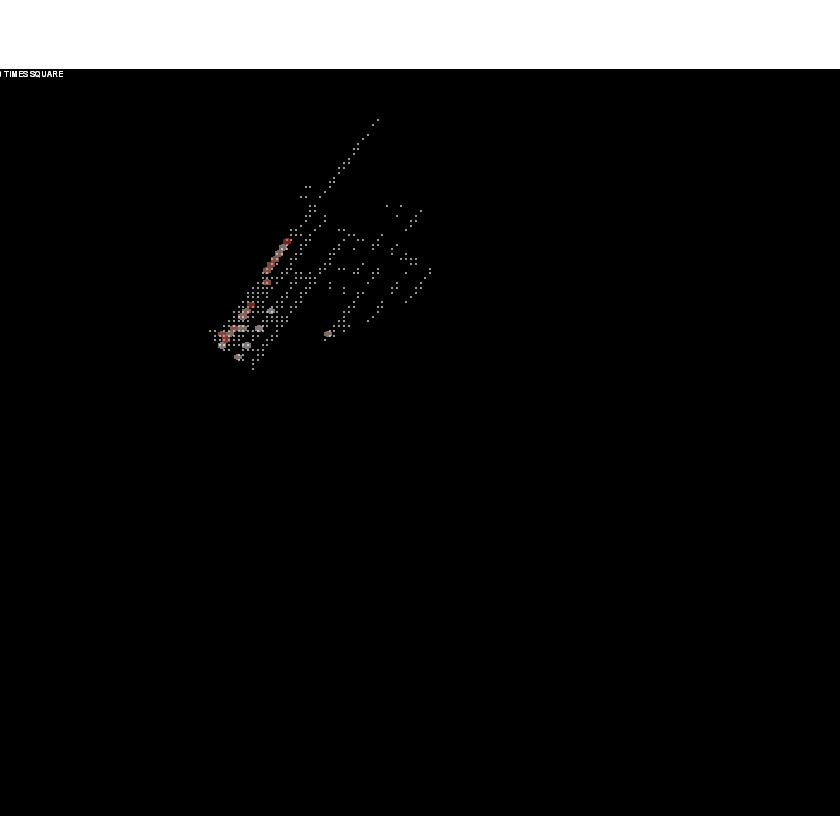

In [97]:
DrawMap(spots[spots$cluster == 2,], "AROUND TIMES SQUARE") 

In [98]:
write.csv(spots, "hotspots.csv") # retain for future use in Visualisation Tools

## 3.8. Visualisation tools - TABLEAU

The images below produced in TableAU and will be visible if this Notebook run from Jupyter. The images can also be visible from the Tableau public location https://public.tableau.com/profile/soliton.scientific

### 3.8.1. Visualisation of Revenue per Weekday per Cluster

<img src="RevenueByWeekday.png" />

## 3.8.2. Visualisation of Best Working Hours

<img src="RevenueByHour.png" />

## 3.8.3. Visualisation of Tableau heatmap of revenue of hours per slots

<img src="RevenueByClusterHour.png" />

# 3.9. Conclusion

Data Science tools offers effective solutions to extract valuable information from Big Data and provide recommendations for drivers, taxi company owners, city planners and travellers. The technical soluton includes dynamic heatmaps, hotspot calculators, city clusters, reusable models for fast identification of next hotspots.
A recommendation to taxi owners is to work optimal hours, pickup best hotspots and minimise waiting time by quickly moving to next hotspot. A recommendatior to Taxi Companies is to diversify a fleet accross major city clusters.
Simply speaking, be in the right spot at the right time.